# Project: Investigating Doctors Appointment Dataset
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


The selected datasheet provides the number of people who have and have not attended their doctors appointment. With the datasheet, we try to determine what percentage of people attend their appointments succesfully and what types of people are likely to attend their appointments. This could include demographics, income levels or health conditions. Using exploratory data anlysis, this project aims to identify these correlations through the following steps:
- Data Cleansing
- Explorative Analysis
- Visualization

We identified that a significant percentage of people do not attend thier appointments, where the majority of them lies in the younger demographic and people in the lower income threshold. Additionally, we also identify that most people dont hold appointments in the weekend, while during the weekdays, Monday & Fridays see less appointments being attended compared to the other week days.

In [4]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('darkgrid')
%matplotlib inline
# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [5]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB



### Data Cleaning

In [6]:
#Removing any Age below 0
df.drop(index = df.query('Age<0').index, inplace = True)
df.query('Age<0')

#checking for duplicates
df.duplicated() == False

#changing PatientId type to int64
df['PatientId'] = df['PatientId'].astype('int64')

#Handicap is only a Boolean, values more than one is not acceptable
df.drop(index = df.query('Handcap >1').index, inplace = True)

#Renaming Column Name to overome TypeError
df.rename(columns = {'No-show':'Noshow'}, inplace = True)

#Converting ScheduledDay and AppointmentDay as DateTime Object
df['ScheduledDay'] = df['ScheduledDay'].apply(lambda x: x.replace('T',''))
df['ScheduledDay'] = df['ScheduledDay'].apply(lambda x: x.replace("Z",''))
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format = '%Y-%m-%d%H:%M:%S')


df['AppointmentDay'] = df['AppointmentDay'].apply(lambda x: x.replace('T',''))
df['AppointmentDay'] = df['AppointmentDay'].apply(lambda x: x.replace("Z",''))
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format = '%Y-%m-%d%H:%M:%S')

#Adding Waiting Time to appointmet to the dataframe
df['Wait_time'] = ((pd.to_datetime(df['AppointmentDay']) - df['ScheduledDay'])/np.timedelta64(1,'h')).round(1)

#Removing any negative waiting time, which indicates appointment dates are before scheduled dates
df.drop (index=df.query('ScheduledDay > AppointmentDay').index, inplace=True)


<a id='eda'></a>
## Exploratory Data Analysis



### Research Question 1: What is the percentage of people showed up successfully for appointments?

Text(0.5, 1.0, '% Representation of Unsuccesful Appointments')

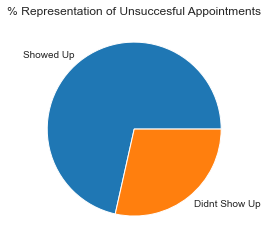

In [9]:
#graphical representation
df['PatientId'] = df['PatientId'].astype('int64')

noshow_percent = df['Noshow'].value_counts(normalize = True).mul(100).round(1)

plt.pie(noshow_percent, labels = ['Showed Up', 'Didnt Show Up'])

plt.title('% Representation of Unsuccesful Appointments')


### Research Question 2: How does Age determine if the person shows up for the appointment or not?

[0, 19, 39, 57, 115]

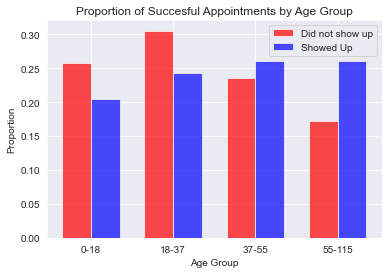

In [15]:
#Creating Age Bins
age_bin = list(df.Age.describe().astype('int64'))[3:8]
bin_names =['0-18', '19-37', '38-55', '56 - 115']
df['Age_bins'] = pd.cut(df['Age'], age_bin, labels = bin_names)

#finding no. of people attended or did not attend their appointments based on age bins
age_counts = df.groupby(['Noshow', 'Age_bins']).count()['PatientId']

#finding no. of people attended or did not attend their appointments 
noshow_counts = df.groupby(['Noshow']).count()['PatientId']

#taking count as a proportion
yes_count = age_counts['Yes']/noshow_counts['Yes']
no_count = age_counts['No']/noshow_counts['No']

#plotting 2d graph for comparison
ind = np.arange(len(yes_count))
width =0.35

yes = plt.bar(ind,yes_count, width, color ='r', alpha =.7, label= 'Did not show up' ),

no = plt.bar(ind+width,no_count, width, color ='b', alpha =.7, label= 'Showed Up' ),
plt.legend(),
plt.ylabel('Proportion')
plt.xlabel('Age Group')
plt.title('Proportion of Succesful Appointments by Age Group')
locations = ind + width/2
labels = ['0-18', '18-37','37-55','55-115' ]
plt.xticks(locations,labels),
age_bin

Based on observation, working class age groups from 18 to 37 years old and children are more likely to not show up for their appointments compared to the older age groups.

### Research Question 3: How does Age determine if the person shows up for the appointment or not?

array(['Friday', 'Tuesday', 'Monday', 'Thursday', 'Wednesday', 'Saturday'],
      dtype=object)

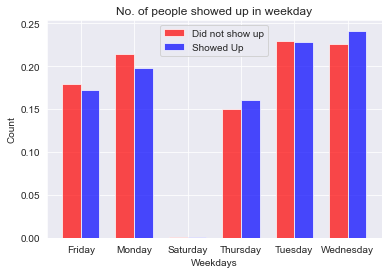

In [16]:
#Adding new columns
df['AppointmentDay_DOW'] = df.AppointmentDay.dt.day_name()
df['ScheduledDay_Date'] = df.ScheduledDay.dt.date
df['AppointmentDay_Date'] = df.AppointmentDay.dt.date

#finding no. of people attended or did not attend their appointments based on weekday
weekday_count= df.groupby(['Noshow','AppointmentDay_DOW'])['PatientId'].count()

#taking count as a proportion
no_weekday = weekday_count['No']/noshow_counts['No']
yes_weekday = weekday_count['Yes']/noshow_counts['Yes']

ind = np.arange(len(yes_weekday))
width = 0.35

yes = plt.bar(ind,yes_weekday, width, color ='r', alpha =.7, label= 'Did not show up' )
no = plt.bar(ind+width,no_weekday, width, color ='b', alpha =.7, label= 'Showed Up' )
plt.legend()
plt.ylabel('Count'),
plt.xlabel('Weekdays'),
plt.title('No. of people showed up in weekday'),
locations = ind + width/2
labels = list(yes_weekday.index)
plt.xticks(locations,labels),
df['AppointmentDay_DOW'].unique()

More people are likely to show up on Wednesdays compared to the rest of the days and they are less likely to show up for their appointments on Monday and Friday. Appointments made on Saturday are insignificant.

### Research Question 4: What other factors determine successful appointments?

,Scholarship,Diabetes,Hipertension,Alcoholism,Handcap,SMS_received
Noshow,,,,,,
No,65.006002,75.056096,76.53068,65.895317,74.936709,72.41428
Yes,34.993998,24.943904,23.46932,34.104683,25.063291,27.58572


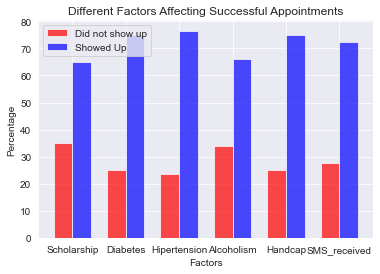

In [17]:
#Sperating each factor from DB and puttin them in to a dataframe
scholarship = df.query('Scholarship == 1').groupby(['Noshow']).count()['Scholarship']/df.query('Scholarship == 1')['Scholarship'].value_counts()[1]*100

diabetes = df.query('Diabetes == 1').groupby(['Noshow']).count()['Diabetes']/df.query('Diabetes == 1')['Diabetes'].value_counts()[1]*100

hipertension = df.query('Hipertension == 1').groupby(['Noshow']).count()['Hipertension']/df.query('Hipertension == 1')['Hipertension'].value_counts()[1]*100

alchololism = df.query('Alcoholism == 1').groupby(['Noshow']).count()['Alcoholism']/df.query('Alcoholism == 1')['Alcoholism'].value_counts()[1]*100

handcap = df.query('Handcap == 1').groupby(['Noshow']).count()['Handcap']/df.query('Handcap == 1')['Handcap'].value_counts()[1]*100

sms = df.query('SMS_received == 1').groupby(['Noshow']).count()['SMS_received']/df.query('SMS_received == 1')['SMS_received'].value_counts()[1]*100

df_new = pd.concat([scholarship,diabetes,hipertension,alchololism,handcap,sms], axis = 1)


#plotting visualization
no_types = df_new.query('Noshow == "No"').iloc[0]
yes_types = df_new.query('Noshow == "Yes"').iloc[0]

ind = np.arange(len(no_types))
width = 0.35

yes_type_bar = plt.bar(ind,yes_types, width, color = 'r', alpha = 0.7,  label= 'Did not show up')
no_type_bar = plt.bar(ind+width,no_types, width, color = 'b', alpha = 0.7,  label= 'Showed Up')
plt.legend()
plt.title('Different Factors Affecting Successful Appointments')
plt.ylabel('Percentage')
plt.xlabel('Factors')
location = ind +width/2
labels = list(df_new.columns)
plt.xticks(locations, labels)

df_new

Data shows that people with medical conditions such as Diabetes, Hipertension, Alcoholism and Handicaps do attend thier appointments, however a good percentage also dont show up. People receiving government grants, i.e. Scholarships still have a higher percentage of not showing up for their appointments compared to the the other factors. 

<a id='conclusions'></a>
## Conclusions

#### Limitations

The dataset had many limitations that required the removal of a small percentage of the dataset as it could not be determined if it was valid data set or not. The data in question here is when the appointment date/time is set before the appointment scheduled time.

Another limitation that was considered was determining whether a person shows up based on multiple variables for e.g. Are people in the age group of 19-37 with scholarship are likely to show up if they have any other medical conditions such as diabetes, hipertension. Performining this action removes the number of reliable data to make an adequate assumption

#### Conclusions

In conclusion, we can confirm on the following based on our findings:

- About 30% of people tend not show up for their appointments.

- Appointments are made mainly in the weekdays, where people are likley to show up if they have booked it in for Wednesday or Thursday. If it has been booked in for Monday or Friday, they are less likely to show up. 

- People in the age group from 0-36 are more likely to not show up for their appointments compared to the older age group. 

- People with scholarship are in the lower income threshold, i.e. below the poverty line. Based on our finding more than 30% receiving scholarships do not show up for their appointments. 

#### References

About each dataset column: https://www.kaggle.com/joniarroba/noshowappointments

About Scholarships: https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia